**HOMEWORK**  

The goal of this homework is to create a regression model for predicting housing prices (column 'median_house_value').  

In this homework we'll again use the California Housing Prices dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices) or download using wget link mentioned below:

```
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

```



In [1]:
#@ IMPORTING LIBRARIES AND DEPENDENCIES:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
#@ DOWNLOADING THE DATASET: UNCOMMENT BELOW:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

--2022-10-18 22:40:25--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: ‘housing.csv’

housing.csv         100%[===================>]   1.36M  6.19MB/s    in 0.2s    

2022-10-18 22:40:26 (6.19 MB/s) - ‘housing.csv’ saved [1423529/1423529]



In [47]:
#@ READING DATASET:
PATH = "./housing.csv"
select_cols = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "median_house_value", "ocean_proximity"]
df = pd.read_csv(PATH, usecols=select_cols)
df.total_bedrooms = df.total_bedrooms.fillna(0)

- Apply the log transform to `median_house_value`. 
- Do train/validation/test split with 60%/20%/20% distribution.
- Use the `train_test_split` function and set the `random_state parameter` to 1.

In [48]:
#@ SPLITTING THE DATASET FOR TRAINING AND TEST:
train_subset, test = train_test_split(df, test_size=0.2, random_state=1)
train, val = train_test_split(train_subset, test_size=0.25, random_state=1)  

In [49]:
train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
9107,-118.18,34.63,19.0,3562.0,606.0,1677.0,578.0,4.1573,228100.0,INLAND
13999,-116.90,34.69,10.0,337.0,102.0,108.0,50.0,0.4999,55000.0,INLAND
5610,-118.26,33.78,27.0,1672.0,491.0,1723.0,462.0,2.0458,174500.0,NEAR OCEAN
13533,-117.33,34.17,5.0,4718.0,1140.0,2564.0,1056.0,2.9877,119900.0,INLAND
2953,-119.02,35.35,42.0,1239.0,251.0,776.0,272.0,1.9830,63300.0,INLAND


- We will use `DictVectorizer` to turn train and validation into matrices.

In [59]:
#@ IMPLEMENTATION OF DICTVECTORIZER:
features = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
            "median_income", "ocean_proximity"]
target = 'median_house_value'

X_train = train[features]
X_val = val[features]
X_test = test[features]

y_train = np.log(train[target])
y_val = np.log(val[target])
y_test = np.log(test[target])

dv = DictVectorizer(sparse=False)
X_train_dict = X_train.to_dict(orient='records')
X_val_dict = X_val.to_dict(orient='records')
X_test_dict = X_test.to_dict(orient='records')

X_train_data = dv.fit_transform(X_train_dict)
X_val_data = dv.transform(X_val_dict)
X_test_data = dv.transform(X_test_dict)

**Question 1**

Let's train a decision tree regressor to predict the `median_house_value` variable.

Train a model with `max_depth=1`.

In [68]:
#@ TRAINING THE REGRESSION MODEL:
model = DecisionTreeRegressor(max_depth=1)
model.fit(X_train_data, y_train)

DecisionTreeRegressor(max_depth=1)

In [69]:
dv.get_feature_names()

/Users/bajajn/anaconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity=<1H OCEAN',
 'ocean_proximity=INLAND',
 'ocean_proximity=ISLAND',
 'ocean_proximity=NEAR BAY',
 'ocean_proximity=NEAR OCEAN',
 'population',
 'total_bedrooms',
 'total_rooms']

In [71]:
#@ INSPECTION:
print(export_text(decision_tree=model, feature_names=list(dv.get_feature_names_out())))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



- Which feature is used for splitting the data?

- Answer:

**Question 2**

Train a random forest model with these parameters:

- `n_estimators=10`  
- `random_state=1`  
- `n_jobs=-1` (optional-to make training faster)

In [72]:
#@ TRAINING RANDOM FOREST MODEL:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train_data, y_train)


RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [73]:
#@ CALCULATING MEAN SQUARED ERROR:
predictions = rf.predict(X_val_data)
rmse = mean_squared_error(y_val, predictions, squared=False)
print(f'rmse is {rmse}')

rmse is 0.2453588910676007


- What's the RMSE of this model on validation?

- Answer: 

**Question 3**

Now, let's experiment with the `n_estimators` parameter.

- Try different values of this parameter from 10 to 200 with step 10.
- Set `random_state` to 1.
- Evaluate the model on the validation dataset.

In [76]:
#@ TRAINING THE RANDOM FOREST MODEL:
estimators = np.arange(10, 210, step=10)
scores = []

for est in estimators:
    rf = RandomForestRegressor(n_estimators=est, random_state=1, n_jobs=-1)
    rf.fit(X_train_data, y_train)
    predictions = rf.predict(X_val_data)
    rmse = mean_squared_error(y_val, predictions, squared=False)
    scores.append((est, rmse))

Text(0.5, 0, 'Number of trees')

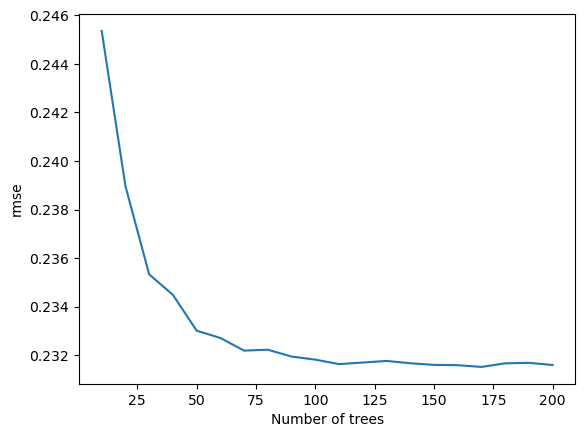

In [80]:
#@ INSPECTING THE RMSE SCORES:
df = pd.DataFrame(data=scores, columns=['estimators', 'val_rmse'])
plt.plot(df.estimators, df.val_rmse)
plt.ylabel('rmse')
plt.xlabel('Number of trees')


# Answer is 150

- After which value of `n_estimators` does RMSE stop improving?

- Answer: 

**Question 4**

Let's select the best `max_depth`:

- Try different values of `max_depth`: [10, 15, 20, 25].
- For each of these values, try different values of n_estimators from 10 till 200 (with step 10).
- Fix the random seed: `random_state=1`.

In [81]:
#@ TRAINING THE MODEL WITH DEPTH:
depths = [10, 15, 20, 25]
scores = []
for est in estimators:
    for dep in depths:
        rf = RandomForestRegressor(n_estimators=est, max_depth=dep, random_state=1, n_jobs=-1)
        rf.fit(X_train_data, y_train)
        predictions = rf.predict(X_val_data)
        rmse = mean_squared_error(y_val, predictions, squared=False)
        scores.append((est, dep, rmse))


Text(0.5, 0, 'Number of trees')

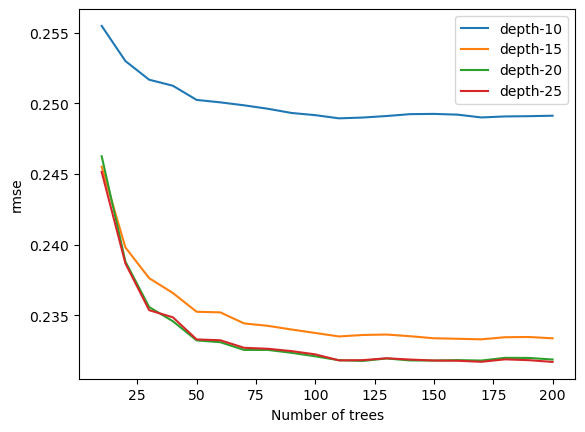

In [84]:
df = pd.DataFrame(data=scores, columns=['estimators', 'depth', 'val_rmse'])
for dep in depths:
    df_subset = df[df.depth == dep].reset_index(drop=True)
    plt.plot(df_subset.estimators, df_subset.val_rmse, label=f"depth-{str(dep)}")
plt.ylabel('rmse')
plt.legend()
plt.xlabel('Number of trees')

#Answer is 20 or 25, we can choose 20


- What's the best `max_depth`:

- Answer:

**Question 5**

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorith, it finds the best split. When doint it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the imporatant features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field.

For this homework question, we'll find the most important feature:

Train the model with these parametes:
- `n_estimators=10`,
- `max_depth=20`,
- `random_state=1`,
- `n_jobs=-1` (optional)

Get the feature importance information from this model

In [88]:
#@ TRAINING THE RANDOM FOREST MODEL:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train_data, y_train)

importances = rf.feature_importances_
features = list(dv.get_feature_names_out())

forest_importances = pd.Series(importances, index=features)
print(forest_importances.sort_values(ascending=False))

median_income                 0.363890
ocean_proximity=INLAND        0.310901
latitude                      0.100636
longitude                     0.096873
housing_median_age            0.032923
population                    0.030010
total_rooms                   0.020914
total_bedrooms                0.019050
households                    0.016888
ocean_proximity=NEAR OCEAN    0.004220
ocean_proximity=<1H OCEAN     0.003067
ocean_proximity=ISLAND        0.000359
ocean_proximity=NEAR BAY      0.000270
dtype: float64


- What's the most important feature?

- Answer:

**Question 6**

Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

- Install XGBoost.
- Create DMatrix for train and validation
- Create a watchlist
- Train a model with these parameters for 100 rounds:

```
xgb_params = {  
    'eta': 0.3,  
    'max_depth': 6,  
    'min_child_weight': 1,  

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
```



In [89]:
#@ CREATING THE DMARTIX:
features = dv.feature_names_

regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

dtrain = xgb.DMatrix(X_train_data, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val_data, label=y_val, feature_names=features)

In [93]:
scores = []
watchlist = [(dtrain, 'train'), (dval, 'val')]
for et in [0.1, 0.3]:
    xgb_params = {
        'eta': et, 
        'max_depth': 6,
        'min_child_weight': 1,
        
        'objective': 'reg:squarederror',
        'nthread': 8,
        
        'seed': 1,
        'verbosity': 1,
    }
    xg = xgb.train(params=xgb_params, dtrain=dtrain, num_boost_round=100, evals=watchlist)
    predictions = xg.predict(dval)
    rmse = mean_squared_error(y_val, predictions, squared=False)
    scores.append((et, rmse))


df = pd.DataFrame(data=scores, columns=['et', 'val_rmse'])
df.sort_values(by='val_rmse')

[0]	train-rmse:10.44371	val-rmse:10.44937
[1]	train-rmse:9.40118	val-rmse:9.40684
[2]	train-rmse:8.46290	val-rmse:8.46830
[3]	train-rmse:7.61859	val-rmse:7.62390
[4]	train-rmse:6.85878	val-rmse:6.86366
[5]	train-rmse:6.17511	val-rmse:6.17976
[6]	train-rmse:5.55996	val-rmse:5.56444
[7]	train-rmse:5.00644	val-rmse:5.01079
[8]	train-rmse:4.50846	val-rmse:4.51263
[9]	train-rmse:4.06044	val-rmse:4.06456
[10]	train-rmse:3.65747	val-rmse:3.66144
[11]	train-rmse:3.29493	val-rmse:3.29852
[12]	train-rmse:2.96890	val-rmse:2.97268
[13]	train-rmse:2.67580	val-rmse:2.67960
[14]	train-rmse:2.41209	val-rmse:2.41607
[15]	train-rmse:2.17503	val-rmse:2.17860
[16]	train-rmse:1.96209	val-rmse:1.96592
[17]	train-rmse:1.77071	val-rmse:1.77456
[18]	train-rmse:1.59876	val-rmse:1.60289
[19]	train-rmse:1.44451	val-rmse:1.44902
[20]	train-rmse:1.30614	val-rmse:1.31096
[21]	train-rmse:1.18108	val-rmse:1.18618
[22]	train-rmse:1.06956	val-rmse:1.07525
[23]	train-rmse:0.96911	val-rmse:0.97509
[24]	train-rmse:0.87978	

,et,val_rmse
1,0.3,0.227837
0,0.1,0.232453


- Now, change eta from 0.3 to 0.1

- Which eta leads to the best RMSE score on the validation dataset?

- Answer: